### Binay Classification
[bosch](https://www.kaggle.com/c/bosch-production-line-performance/data)

In addition to being one of the largest datasets (in terms of number of features) ever hosted on Kaggle,
the ground truth for this competition is highly imbalanced. Together, these two attributes are expected 
to make this a challenging problem.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

## Useful links in Kaggle

### [Production map](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/23042/production-map)

### [Expeditive exploration+models on data](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22909/expeditive-exploration-models-on-data)

### [Visulization of data exploration](https://www.kaggle.com/dollardollar/bosch-production-line-performance/eda-of-important-features/comments)

### [H20](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/23146/xgboost-simple-starter-auc-0-712)

### [DataSize](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/22908/datasets-size-uncompressed-14-3gb)

### [Turn categorical into numeric](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/23290/turn-categorical-into-numeric)

## [Magic feature](https://www.kaggle.com/c/bosch-production-line-performance/forums/t/24065/the-magical-feature-from-lb-0-3-to-0-4/137761#post137761)

In [21]:
# ratio between positive samples and negative samples
ratio=6879/1176868

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


feature_names = ['L3_S38_F3960', 'L3_S33_F3865', 'L3_S38_F3956', 'L3_S33_F3857',
       'L3_S29_F3321', 'L1_S24_F1846', 'L3_S32_F3850', 'L3_S29_F3354',
       'L3_S29_F3324', 'L3_S35_F3889', 'L0_S1_F28', 'L1_S24_F1844',
       'L3_S29_F3376', 'L0_S0_F22', 'L3_S33_F3859', 'L3_S38_F3952', 
       'L3_S30_F3754', 'L2_S26_F3113', 'L3_S30_F3759', 'L0_S5_F114']

In [5]:
numeric_cols = pd.read_csv("bosch/train_numeric.csv", nrows = 1).columns.values
imp_idxs = [np.argwhere(feature_name == numeric_cols)[0][0] for feature_name in feature_names]
train = pd.read_csv("bosch/train_numeric.csv", 
                index_col = 0, header = 0, usecols = [0, len(numeric_cols) - 1] + imp_idxs)
train = train[feature_names + ['Response']]

In [6]:
X_neg, X_pos = train[train['Response'] == 0].iloc[:, :-1], train[train['Response']==1].iloc[:, :-1]

In [7]:
BATCH_SIZE = 5
train_batch =[pd.melt(train[train.columns[batch: batch + BATCH_SIZE].append(np.array(['Response']))], 
                      id_vars = 'Response', value_vars = feature_names[batch: batch + BATCH_SIZE])
              for batch in list(range(0, train.shape[1] - 1, BATCH_SIZE))]

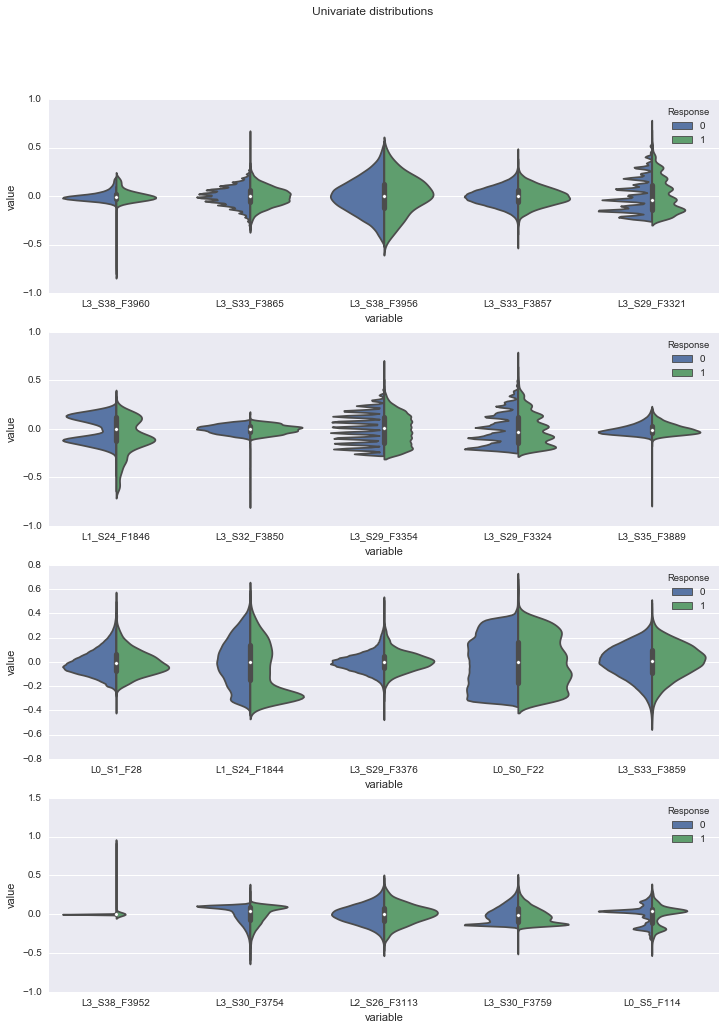

In [8]:
FIGSIZE = (12,16)
_, axs = plt.subplots(len(train_batch), figsize = FIGSIZE)
plt.suptitle('Univariate distributions')
for data, ax in zip(train_batch, axs):
    sns.violinplot(x = 'variable',  y = 'value', hue = 'Response', data = data, ax = ax, split =True)

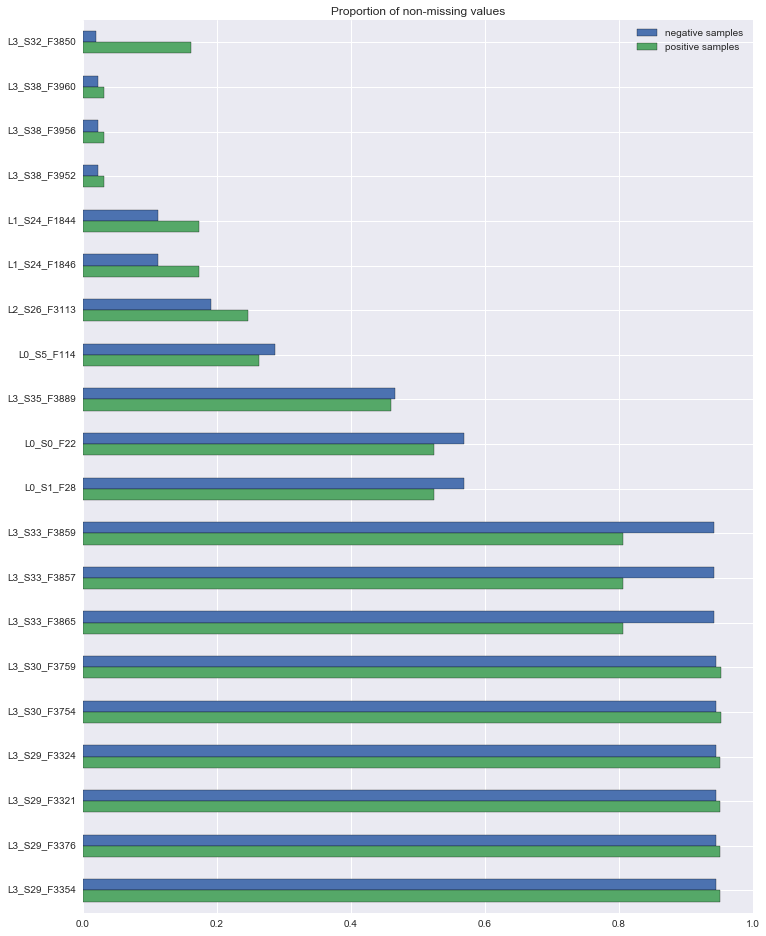

In [9]:
non_missing = pd.DataFrame(pd.concat([(X_neg.count()/X_neg.shape[0]).to_frame('negative samples'),
                                      (X_pos.count()/X_pos.shape[0]).to_frame('positive samples'),  
                                      ], 
                       axis = 1))
non_missing_sort = non_missing.sort_values(['negative samples'])
non_missing_sort.plot.barh(title = 'Proportion of non-missing values', figsize = FIGSIZE)
plt.gca().invert_yaxis()

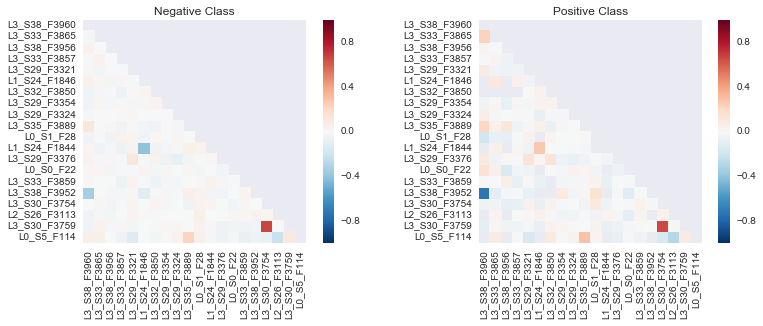

In [11]:
FIGSIZE = (13,4)
_, (ax1, ax2) = plt.subplots(1,2, figsize = FIGSIZE)
MIN_PERIODS = 100

triang_mask = np.zeros((X_pos.shape[1], X_pos.shape[1]))
triang_mask[np.triu_indices_from(triang_mask)] = True

ax1.set_title('Negative Class')
sns.heatmap(X_neg.corr(min_periods = MIN_PERIODS), mask = triang_mask, square=True,  ax = ax1)

ax2.set_title('Positive Class')
sns.heatmap(X_pos.corr(min_periods = MIN_PERIODS), mask = triang_mask, square=True,  ax = ax2)



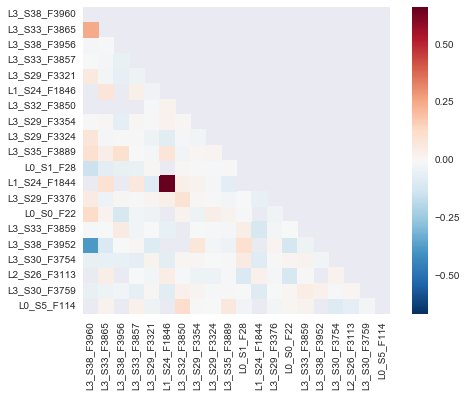

In [12]:
sns.heatmap(X_pos.corr(min_periods = MIN_PERIODS) -X_neg.corr(min_periods = MIN_PERIODS), 
             mask = triang_mask, square=True)


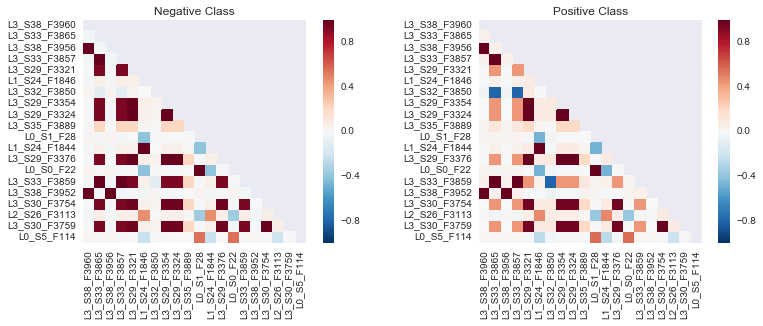

In [13]:
nan_pos, nan_neg = np.isnan(X_pos), np.isnan(X_neg)

triang_mask = np.zeros((X_pos.shape[1], X_pos.shape[1]))
triang_mask[np.triu_indices_from(triang_mask)] = True

FIGSIZE = (13,4)
_, (ax1, ax2) = plt.subplots(1,2, figsize = FIGSIZE)
MIN_PERIODS = 100

ax1.set_title('Negative Class')
sns.heatmap(nan_neg.corr(),   square=True, mask = triang_mask, ax = ax1)

ax2.set_title('Positive Class')
sns.heatmap(nan_pos.corr(), square=True, mask = triang_mask,  ax = ax2)

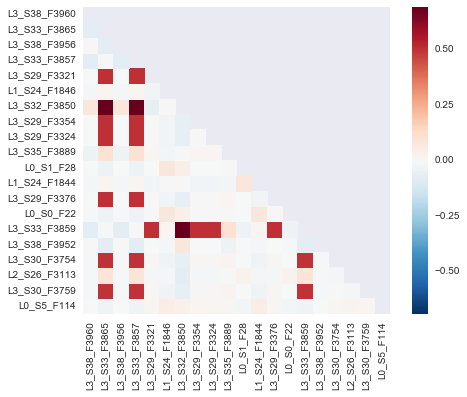

In [14]:
sns.heatmap(nan_neg.corr() - nan_pos.corr(), mask = triang_mask, square=True)

## Train all numeric features

In [15]:
train = pd.read_csv("bosch/train_numeric.csv")

### Train

In [38]:
import xgboost as xgb
Y=train['Response']
listp=[x for x in train.columns if x not in ["Response"]]
len(listp)
X=train[listp]

import time
startt = time.time()
gbm = xgb.XGBClassifier(max_depth=7, n_estimators=30, learning_rate=0.05).fit(X, Y)
endt = time.time()
print((endt-startt)/60)



27.20023311773936


In [39]:
## max_depth=3, n_estimators=30, learning_rate=0.05, MCC:  2.3118949470266887, time: 13.2min
## max_depth=5, n_estimators=30, learning_rate=0.05, MCC:  2.6920021339353273, time: 19.7min
## max_depth=6, n_estimators=30, learning_rate=0.05, MCC:  2.84,               time: 23.3min
## max_depth=7, n_estimators=30, learning_rate=0.05, MCC:  3.13                time: 27.2min

## Feature Importance

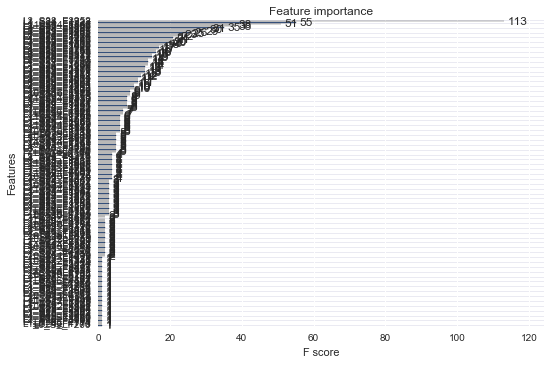

In [40]:
xgb.plot_importance(gbm)

### Predict

In [41]:
import time
import math
startt = time.time()
predictions = gbm.predict(X)
sumn=0
TP=0
TN=0
FP=0
FN=0
for i in range(len(predictions)):
    if predictions[i]==0:
        if predictions[i]!=Y.iloc[i]:
            FN = FN+1
        else:
            TN = TN+1
    else:
        if predictions[i]!=Y.iloc[i]:
            FP = FP+1
        else:
            TP = TP+1

endt = time.time()
print((endt-startt)/60)
sumup=TP*TN-FP*FN
sumdown=(TP+FP)*(TP+FN)*(FN+FP)*(TN+FN)*1.0
print("MCC: ",sumup/math.sqrt(sumdown))

1.9202057679494222
MCC:  3.1340496587475624


## Train all categorical feature

In [3]:
pd.read_csv?

In [3]:
pd.read_csv?

In [2]:
train = pd.read_csv("bosch/train_categorical.csv",dtype=float)

In [3]:
train.head()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train = train.fillna(0)

In [5]:
pd.read_csv?

In [5]:
train['Id'] = train['Id'].astype(int)

In [6]:
trainl = pd.read_csv("bosch/train_numeric.csv",usecols=['Response','Id'])

In [7]:
Y=trainl['Response']

In [8]:
train.shape

(1183747, 2141)

In [16]:
sum(Y[500:600])

1

In [17]:
from sklearn import tree
from sklearn import linear_model

In [12]:
tree.DecisionTreeClassifier?

In [18]:

listp=[x for x in train.columns if x not in ["Response","Id"]]
len(listp)
#train[listp]

import time
startt = time.time()
# clf = tree.DecisionTreeClassifier(max_depth=3)
# clf = clf.fit(train[listp], Y)

clf = linear_model.SGDClassifier()
clf.fit(train[listp].iloc[500:600], Y[500:600])

endt = time.time()
print((endt-startt)/60)

0.5618971029917399


In [ ]:
import xgboost as xgb
import time
startt = time.time()
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=3, learning_rate=0.1).fit(train[listp].iloc[500:600], Y[500:600])
endt = time.time()
print((endt-startt)/60)

## Get positive samples

In [5]:
numericnum=970
categorical=2140
date=1156

In [20]:
import warnings
warnings.filterwarnings('ignore')

def get_positive(chunksize):
    reader_numeric = pd.read_csv('bosch/train_numeric.csv', chunksize=chunksize)
    reader_categorical = pd.read_csv('bosch/train_categorical.csv', chunksize=chunksize)
    reader_date = pd.read_csv('bosch/train_date.csv', chunksize=chunksize)
    reader = zip(reader_numeric, reader_categorical, reader_date)
    first = True
    for numeric, categorical, date in reader:
        categorical.drop('Id', axis=1, inplace=True)
        date.drop('Id', axis=1, inplace=True)
        data = pd.concat([numeric, categorical, date], axis=1)
        positive_data = data[data.Response == 1]
        if first:
            positive = positive_data.copy()
            first = False
        else:
            positive = pd.concat([positive, positive_data])
        print(positive_data.shape, positive.shape)
    return positive

positive = get_positive(10000)

(53, 4266) (53, 4266)
(59, 4266) (112, 4266)
(57, 4266) (169, 4266)
(50, 4266) (219, 4266)
(52, 4266) (271, 4266)
(52, 4266) (323, 4266)
(61, 4266) (384, 4266)
(59, 4266) (443, 4266)
(71, 4266) (514, 4266)
(54, 4266) (568, 4266)
(59, 4266) (627, 4266)
(53, 4266) (680, 4266)
(38, 4266) (718, 4266)
(62, 4266) (780, 4266)
(55, 4266) (835, 4266)
(48, 4266) (883, 4266)
(75, 4266) (958, 4266)
(68, 4266) (1026, 4266)
(51, 4266) (1077, 4266)
(52, 4266) (1129, 4266)
(55, 4266) (1184, 4266)
(45, 4266) (1229, 4266)
(41, 4266) (1270, 4266)
(55, 4266) (1325, 4266)
(85, 4266) (1410, 4266)
(54, 4266) (1464, 4266)
(55, 4266) (1519, 4266)
(69, 4266) (1588, 4266)
(58, 4266) (1646, 4266)
(49, 4266) (1695, 4266)
(61, 4266) (1756, 4266)
(66, 4266) (1822, 4266)
(59, 4266) (1881, 4266)
(62, 4266) (1943, 4266)
(58, 4266) (2001, 4266)
(75, 4266) (2076, 4266)
(49, 4266) (2125, 4266)
(57, 4266) (2182, 4266)
(72, 4266) (2254, 4266)
(62, 4266) (2316, 4266)
(58, 4266) (2374, 4266)
(58, 4266) (2432, 4266)
(61, 4266)